In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from models import * 
# from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
# from util_in_multi_h5_unnorm import *
from utilities import *

# from AST import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py
import socket
import statsmodels.api as sm
import time
import csv
from IPython.display import FileLink

import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
def make_index_dict(label_csv):
    index_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            index_lookup[row['index']] = row['display_name'] #addtional col mid
            line_count += 1
    return index_lookup
label_csv = '/jet/home/billyli/data_folder/AllaboutAudioSet/egs/audioset/data/class_labels_indices.csv'
class_dic = make_index_dict(label_csv)

In [3]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

17796247


In [4]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [5]:
def plot_single_result(data):
    class_performance_np = np.array(data)

    # Sort by performance
    sorted_indices = np.argsort(class_performance_np[:, 0])
    sorted_data = class_performance_np[sorted_indices]

    # Separate the class_ids and performances
    class_ids = sorted_data[:, 1]
    performances = sorted_data[:, 0]

    new_index = np.arange(len(class_ids))

    # Plot the data
    plt.figure(figsize=(10,6))
    plt.scatter(new_index, performances)
    plt.title('Class-wise Performance')
    plt.ylabel('mAP')
    plt.xlabel('Class Index')
    plt.show()

In [6]:
# Use a white background
def plot_pair_data(data0, data1, label0, label1):
    plt.style.use('seaborn-whitegrid')
    class_performance = data0
    class_performance2 = data1
    # Convert the lists to numpy arrays
    class_performance_np = np.array(class_performance)
    class_performance_np2 = np.array(class_performance2)
    outperforms = np.sum(class_performance_np2  > class_performance_np)
    print(f"{outperforms} of {label1} outperformed {label0}")
    # Sort by performance for the first run
    sorted_indices = np.argsort(class_performance_np[:, 0])
    sorted_data = class_performance_np[sorted_indices]

    # Separate the class_ids and performances
    class_ids = sorted_data[:, 1]
    performances = sorted_data[:, 0]

    # Create new index according to sorted order
    new_index = np.arange(len(class_ids))

    # Create a mapping from class_id to new index
    class_id_to_new_index = {class_id: index for index, class_id in enumerate(class_ids)}

    # Get the corresponding new indices for the second run
    new_index2 = np.array([class_id_to_new_index[class_id] for class_id in class_performance_np2[:, 1]])
    performances2 = class_performance_np2[:, 0]

    # Fit a loess curve to the data
    loess = sm.nonparametric.lowess(performances2, new_index2, frac=0.3)

    # Plot the data and the loess curve
    plt.figure(figsize=(10,6))
    plt.scatter(new_index, performances, color='blue', alpha=0.2, label=label0)

    plt.scatter(new_index2, performances2, color='red', alpha=0.2, label=label1)
    plt.plot(loess[:, 0], loess[:, 1], color='red', linestyle='dotted', linewidth=3)
    plt.title('Class-wise Performance')
    plt.ylabel('mAP')
    plt.xlabel('Class Index')
    plt.legend()
    plt.savefig(f'performance_classwise_{label0}_{label1}.png', dpi=300)

    plt.show()
    return FileLink(f'performance_classwise_{label0}_{label1}.png')

In [7]:
def calculate_result(new_gas_eval):
    result = []
    batch_size =100
    x = new_gas_eval 
    # x = new_gas_eval
    # x = gas_eval_x1_origin
    for i in range(0, len(x), batch_size):
        with torch.no_grad():
            input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
            output = model.forward(input)
    #                 print(output)
            output = torch.sigmoid(output)
    #                 print(f'output shape: {output.shape}')
    #                 print(output)
            result.append([output.data.cpu().numpy()])
    print('total num of batches during testing', len(result))
    result = [numpy.concatenate(items) for items in zip(*result)]
    gas_eval_global_prob_multi = result[0]
    print('Performance on Google Audio Set:')
    print("   CLASS |    AP |   AUC |    d' ")
    FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
    SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
    print(SEP)
    classwise = []
    N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
    for i in range(N_CLASSES):
        a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
        classwise.append((a, b, c))
    map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
    print(FORMAT % ('Average', map, mauc, dprime(mauc)))
    print(SEP)
    for i in range(N_CLASSES):
        print(FORMAT % ((str(i),) + classwise[i]))
    classwise_data = [[v[0], i] for i, v in enumerate(classwise)]
    return classwise_data, gas_eval_global_prob_multi

In [8]:
def calculate_result_torch(new_gas_eval):
    result = []
    batch_size = 100
    x = new_gas_eval
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    for i in range(0, len(x), batch_size):
        with torch.no_grad():
            input = torch.tensor(x[i : i + batch_size]).to(device)
            output = model.forward(input)
            output = torch.sigmoid(output)
            result.append(output.data)
    print('total num of batches during testing', len(result))
    result_tensor = torch.cat(result)
    gas_eval_global_prob = result_tensor.cpu().numpy()
    print('Performance on Google Audio Set:')
    print("   CLASS |    AP |   AUC |    d' ")
    FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
    SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
    print(SEP)
    classwise = []
    N_CLASSES = gas_eval_global_prob.shape[-1]
    for i in range(N_CLASSES):
        a, b, c = gas_eval(gas_eval_global_prob[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
        classwise.append((a, b, c))
    map, mauc = np.array(classwise).mean(axis = 0)[:2]
    print(FORMAT % ('Average', map, mauc, dprime(mauc)))
    print(SEP)
    for i in range(N_CLASSES):
        print(FORMAT % ((str(i),) + classwise[i]))
    classwise_data = [[v[0], i] for i, v in enumerate(classwise)]
    return classwise_data, gas_eval_global_prob

In [9]:
def plot_binary_confusion(glob_prob):
    # convert to binary labels
    glob_prob_binary = np.where(glob_prob > 0.5, 1, 0)

    # calculate the multilabel confusion matrix
    confusion_matrices = multilabel_confusion_matrix(gas_eval_y, glob_prob_binary)

    classes_to_plot = [0, 1, 2, 3, 4]  # replace with your chosen classes

    for i in classes_to_plot:
        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Class {i}')
        plt.show()


In [10]:
def multiclass_confusion_matrix_numpy(y_true, y_pred):
    conf_matrix = np.zeros((y_true.shape[-1], y_true.shape[-1]))
    for actual, pred in zip(y_true, y_pred):
        act_indices =  np.nonzero(actual)[0]
        k = act_indices.shape[0]
        topk_indices = np.argsort(pred)[-k:]
        TP = np.intersect1d(act_indices,topk_indices)
        for hit_ind in TP:
            conf_matrix[hit_ind][hit_ind]+=1
        FN = np.setdiff1d(act_indices, topk_indices)
        FP = np.setdiff1d(topk_indices, act_indices)
        mistakes = [(fn, fp) for fn in FN for fp in FP]
        for act_i, pred_i in mistakes:
            conf_matrix[act_i][pred_i]+=1
    return conf_matrix

In [11]:
def visualize_confusion(confusion_matrix, start_ind=0, end_ind=527):
    # cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    cm_normalized_all = confusion_matrix.astype('float')
    cm_log_scale = np.log1p(cm_normalized_all)

    plt.figure(figsize=(15, 15))
    plt.imshow(cm_log_scale[start_ind:end_ind, start_ind:end_ind] , interpolation='nearest', cmap=plt.cm.Blues)
    # plt.imshow(cm_normalized[250:350, 250:350], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.png", dpi=300)

    plt.show()

    # Display a link to the saved file
    return FileLink('confusion_matrix.png')

In [12]:
def topk_classes_confuse(confusion, axis, k):
    column_sums = confusion.sum(axis=axis)
    top_k_indices = np.argsort(column_sums)[-k:]
    for ind in top_k_indices:
        print(ind, class_dic[str(ind)])
    plt.plot(column_sums)

In [13]:
def naive_confusion_matrix(y_true, y_pred):
#     y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    print(y_true.shape, y_pred.shape)
    # Convert the probability predictions into class predictions
    pred_classes = np.argmax(y_pred, axis=1)
    # sorted_indices = np.argsort(glob_prob0, axis=1)
    # pred_classes = sorted_indices[:, -2]

    true_classes = np.argmax(y_true, axis=1)
    # sorted_truth = np.argsort(gas_eval_y, axis=1)
    # true_classes = sorted_truth[:, -2]
    print(pred_classes.shape, true_classes.shape)
    all_classes = np.arange(527)

    # Compute the confusion matrix
    cm = confusion_matrix(true_classes, pred_classes, labels=all_classes)
    print(cm.shape)
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_log = np.log1p(cm)

    plt.figure(figsize=(15, 15))
    plt.imshow(cm_log, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('1 hot confusion matrix')
    plt.colorbar()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("1-hot-confusion_matrix.png", dpi=300)
    # Display a link to the saved file
    plt.show()
    return FileLink('1-hot-confusion_matrix.png'), cm


In [14]:
def plot_precision_recall_f1(y_true, y_pred):# convert to binary labels
    glob_prob_binary = np.where(y_pred > 0.5, 1, 0)

    # calculate precision, recall, F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, glob_prob_binary)

    # get sorted order by F1 score
    sorted_classes = np.argsort(f1)[::-1]  # reverse for descending order

    # plot precision, recall, F1 for each class in sorted order
    plt.figure(figsize=(15, 10))
    plt.plot(precision[sorted_classes], label='Precision')
    plt.plot(recall[sorted_classes], label='Recall')
    plt.plot(f1[sorted_classes], label='F1')
    plt.xlabel('Class (sorted by F1 score)')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score for Each Class')
    plt.legend()
    plt.show()
    plt.show()

# VICTIM MODEL

In [15]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### AST 64x400 best model

In [16]:
args = parser.parse_args(args=['--model_type=AST','--dataset=audioset_s','--n_mels=64', '--mean=-27.248297','--std=37.681698',
                               '--lr=1e-5','--batch-size=80','--n-epochs=10','--fstride=8','--tstride=8',
                               '--freqm=12','--timem=75','--mixup=0.5',
                               '--imagenet_pretrain=True','--suffix=ast_challenge-40.95'])
args.target_length=400
exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.9.pth')

audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95


### AST 128x1024 best model

In [17]:
# args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
#                                '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
#                                '--freqm=36','--timem=192','--mixup=0.3',
#                                '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
# args.target_length=1024
# exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
# -fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
# print(exp_id)
# WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
# MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [18]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95/models/audio_model.9.pth


In [19]:
args

Namespace(audioset_pretrain=True, bal=None, batch_size=80, dataset='audioset_s', dataset_portion='full', exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, lr='1e-5', lr_patience=2, mean=-27.248297, mixup=0.5, model_type='AST', n_epochs=10, n_mels=64, n_print_steps=100, num_workers=32, optim='adam', std=37.681698, suffix='ast_challenge-40.95', target_length=400, timem=75, tstride=8)

In [20]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
input_fdim: 64,input_tdim: 400
out_shape: torch.Size([1, 768, 7, 49])
f_dim: 7,t_dim: 49, num_patches: 343
frequncey stride=8, time stride=8
number of patches=343
pos_embedding reshaped shape: torch.Size([1, 345, 768])


In [21]:
optimizer = Adam(model.parameters())


In [22]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNo

In [23]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

                            
gas_eval_x1, gas_eval_y = bulk_load(hf_val_eval_path, mu_val, sigma_val)

In [24]:
gas_eval_x1.shape, gas_eval_y.shape, mu_val, sigma_val

((20123, 400, 64), (20123, 527), -27.248297, 37.681698)

# Inference

In [25]:
start_time = time.time()
classwise_data0_np, glob_prob0_np = calculate_result(gas_eval_x1)
end_time = time.time()
print(f"The operation took {end_time - start_time} seconds to complete")


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.409 | 0.973 | 2.715 
---------+-------+-------+-------
       0 | 0.793 | 0.934 | 2.125 
       1 | 0.065 | 0.815 | 1.265 
       2 | 0.093 | 0.923 | 2.016 
       3 | 0.371 | 0.962 | 2.512 
       4 | 0.243 | 0.974 | 2.757 
       5 | 0.088 | 0.952 | 2.352 
       6 | 0.472 | 0.997 | 3.814 
       7 | 0.453 | 0.988 | 3.190 
       8 | 0.144 | 0.945 | 2.258 
       9 | 0.096 | 0.951 | 2.341 
      10 | 0.139 | 0.965 | 2.563 
      11 | 0.186 | 0.978 | 2.849 
      12 | 0.835 | 0.999 | 4.445 
      13 | 0.512 | 0.996 | 3.730 
      14 | 0.336 | 0.987 | 3.143 
      15 | 0.823 | 0.999 | 4.234 
      16 | 0.392 | 0.978 | 2.848 
      17 | 0.604 | 0.993 | 3.486 
      18 | 0.158 | 0.979 | 2.889 
      19 | 0.255 | 0.980 | 2.899 
      20 | 0.358 | 0.990 | 3.277 
      21 | 0.221 | 0.983 | 2.987 
      22 | 0.466 | 0.990 | 3.296 
      23 

In [26]:
start_time = time.time()
classwise_data0, glob_prob0 = calculate_result_torch(gas_eval_x1)
end_time = time.time()
print(f"The operation took {end_time - start_time} seconds to complete")


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.409 | 0.973 | 2.715 
---------+-------+-------+-------
       0 | 0.793 | 0.934 | 2.125 
       1 | 0.065 | 0.815 | 1.265 
       2 | 0.093 | 0.923 | 2.016 
       3 | 0.371 | 0.962 | 2.512 
       4 | 0.243 | 0.974 | 2.757 
       5 | 0.088 | 0.952 | 2.352 
       6 | 0.472 | 0.997 | 3.814 
       7 | 0.453 | 0.988 | 3.190 
       8 | 0.144 | 0.945 | 2.258 
       9 | 0.096 | 0.951 | 2.341 
      10 | 0.139 | 0.965 | 2.563 
      11 | 0.186 | 0.978 | 2.849 
      12 | 0.835 | 0.999 | 4.445 
      13 | 0.512 | 0.996 | 3.730 
      14 | 0.336 | 0.987 | 3.143 
      15 | 0.823 | 0.999 | 4.234 
      16 | 0.392 | 0.978 | 2.848 
      17 | 0.604 | 0.993 | 3.486 
      18 | 0.158 | 0.979 | 2.889 
      19 | 0.255 | 0.980 | 2.899 
      20 | 0.358 | 0.990 | 3.277 
      21 | 0.221 | 0.983 | 2.987 
      22 | 0.466 | 0.990 | 3.296 
      23 

In [27]:
confusion0 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob0)

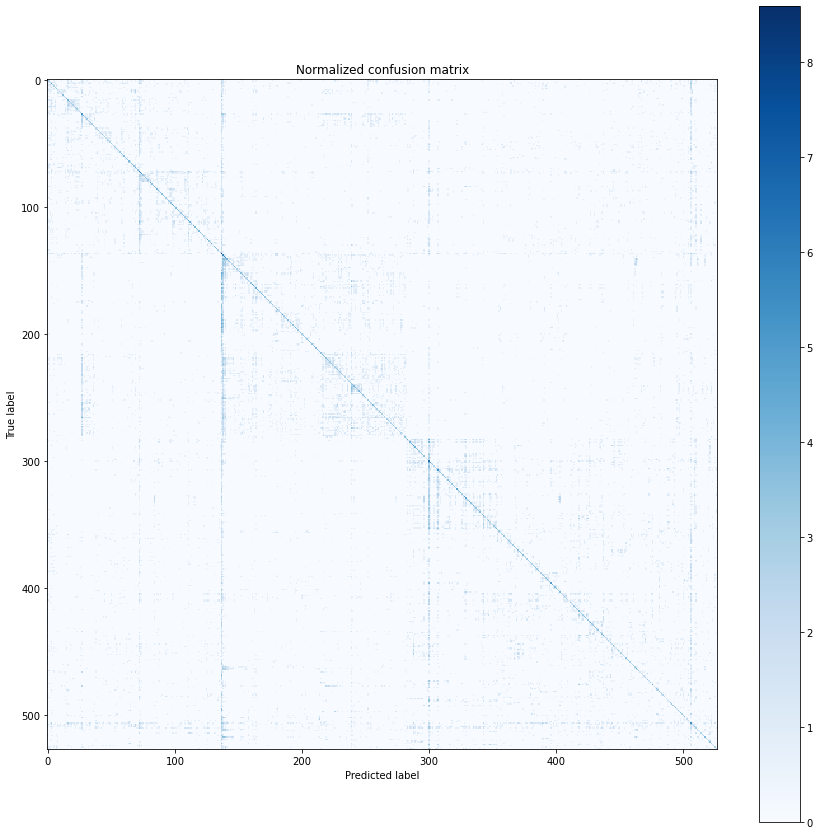

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [28]:
visualize_confusion(confusion0)


(20123, 527) (20123, 527)
(20123,) (20123,)
(527, 527)


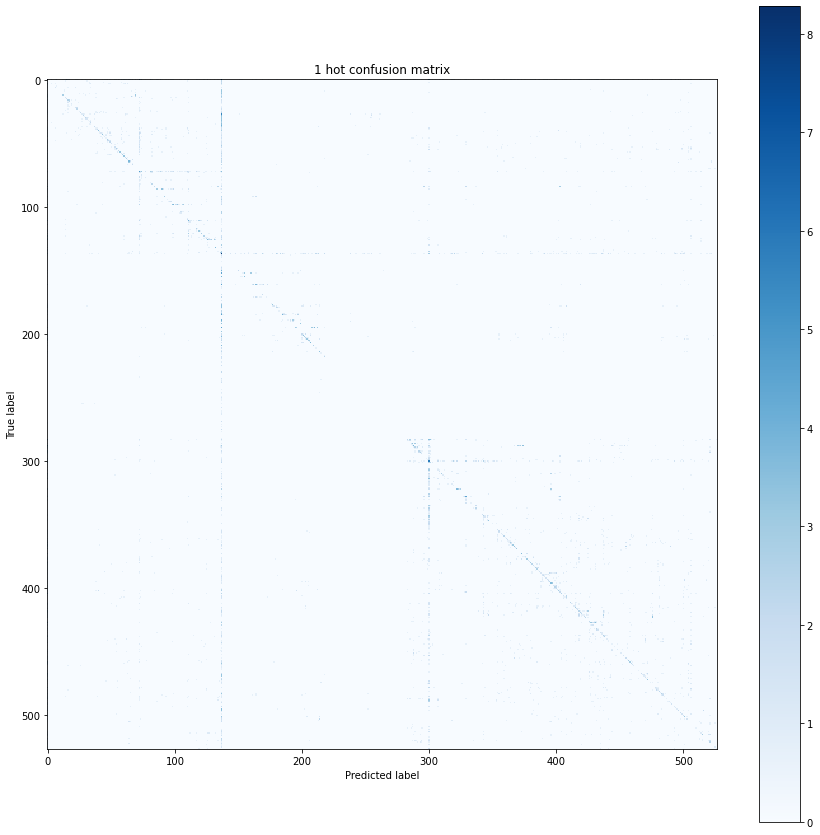

In [29]:
confusion_naive, cm = naive_confusion_matrix(gas_eval_y, glob_prob0)


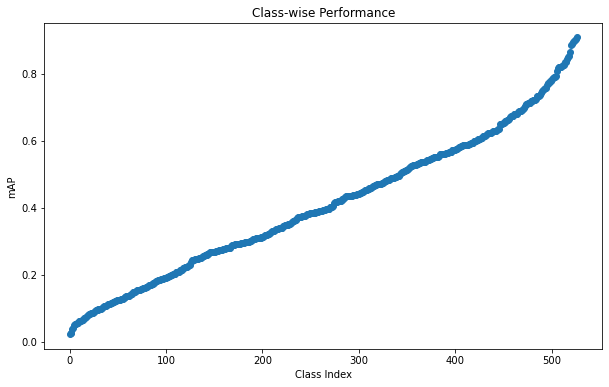

In [30]:
plot_single_result(classwise_data0)

# Occlusion

In [31]:
gas_eval_x1_origin = gas_eval_x1

In [32]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.2922494 1.4197426 -0.158013 0.62080556


In [33]:
gas_eval_x1.shape

(20123, 400, 64)

<h>Occ 4s</h>

In [34]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

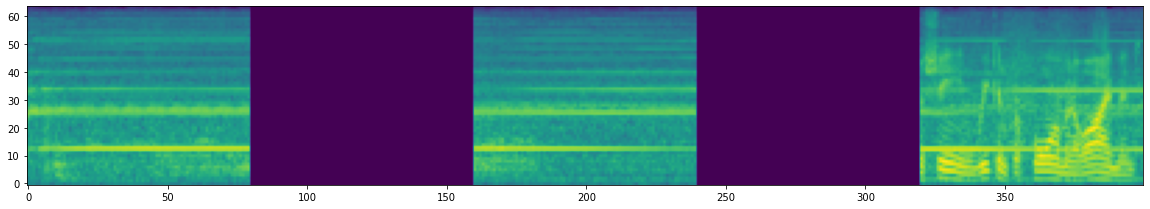

In [35]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [36]:
classwise_data1, glob_prob1= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.358 | 0.964 | 2.541 
---------+-------+-------+-------
       0 | 0.759 | 0.918 | 1.964 
       1 | 0.069 | 0.807 | 1.227 
       2 | 0.086 | 0.915 | 1.945 
       3 | 0.331 | 0.951 | 2.346 
       4 | 0.178 | 0.972 | 2.707 
       5 | 0.064 | 0.949 | 2.316 
       6 | 0.410 | 0.990 | 3.281 
       7 | 0.343 | 0.988 | 3.211 
       8 | 0.117 | 0.937 | 2.169 
       9 | 0.086 | 0.942 | 2.223 
      10 | 0.103 | 0.953 | 2.365 
      11 | 0.201 | 0.974 | 2.756 
      12 | 0.796 | 0.999 | 4.285 
      13 | 0.436 | 0.995 | 3.658 
      14 | 0.258 | 0.971 | 2.687 
      15 | 0.753 | 0.995 | 3.620 
      16 | 0.341 | 0.975 | 2.777 
      17 | 0.553 | 0.992 | 3.433 
      18 | 0.117 | 0.974 | 2.742 
      19 | 0.190 | 0.967 | 2.591 
      20 | 0.310 | 0.987 | 3.157 
      21 | 0.155 | 0.979 | 2.874 
      22 | 0.388 | 0.983 | 3.008 
      23 

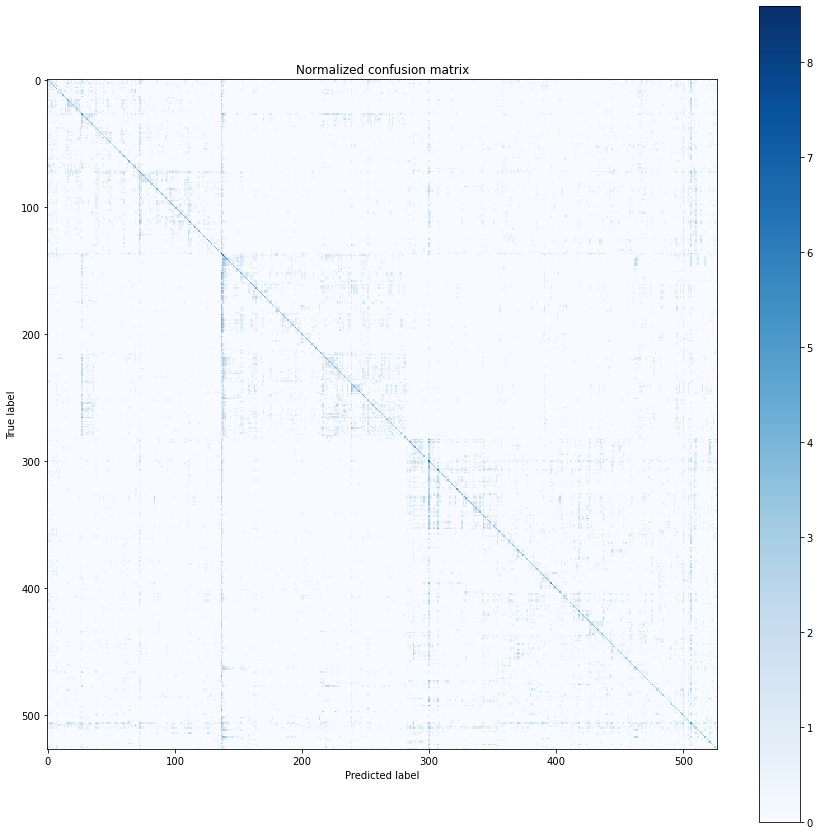

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [37]:
confusion1 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob1)
visualize_confusion(confusion1)

In [38]:
print(type(classwise_data1))

<class 'list'>


54 of occluding 4s outperformed clean


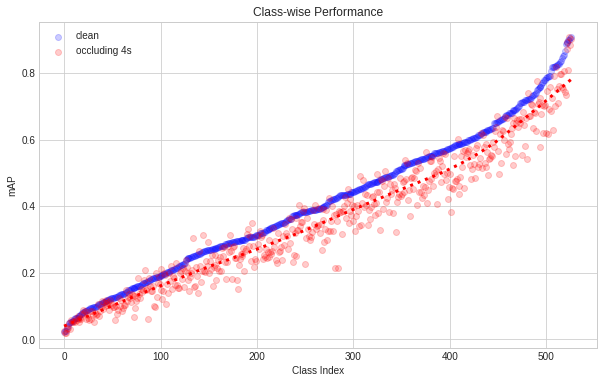

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding 4s.png

In [39]:
plot_pair_data(classwise_data0, classwise_data1, 'clean', 'occluding 4s')

<h>First 5s</h>

In [40]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

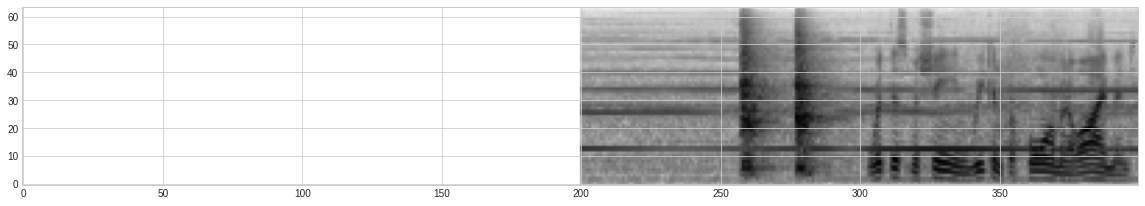

In [41]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [42]:
classwise_data2, glob_prob2= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.319 | 0.947 | 2.284 
---------+-------+-------+-------
       0 | 0.710 | 0.884 | 1.690 
       1 | 0.055 | 0.804 | 1.210 
       2 | 0.080 | 0.914 | 1.930 
       3 | 0.306 | 0.940 | 2.194 
       4 | 0.139 | 0.954 | 2.390 
       5 | 0.049 | 0.951 | 2.337 
       6 | 0.297 | 0.961 | 2.487 
       7 | 0.213 | 0.987 | 3.138 
       8 | 0.111 | 0.928 | 2.065 
       9 | 0.099 | 0.942 | 2.222 
      10 | 0.072 | 0.934 | 2.134 
      11 | 0.129 | 0.942 | 2.225 
      12 | 0.716 | 0.995 | 3.623 
      13 | 0.434 | 0.987 | 3.165 
      14 | 0.263 | 0.970 | 2.670 
      15 | 0.646 | 0.969 | 2.630 
      16 | 0.306 | 0.965 | 2.565 
      17 | 0.410 | 0.987 | 3.155 
      18 | 0.110 | 0.940 | 2.204 
      19 | 0.155 | 0.931 | 2.101 
      20 | 0.310 | 0.969 | 2.645 
      21 | 0.139 | 0.972 | 2.712 
      22 | 0.377 | 0.963 | 2.522 
      23 

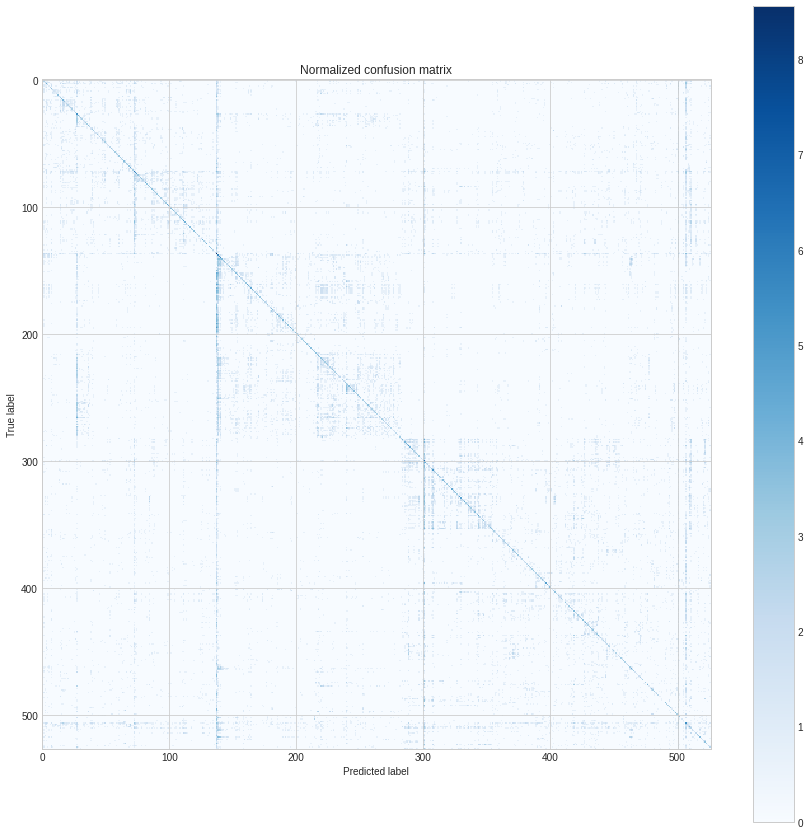

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [43]:
confusion2 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob2)
visualize_confusion(confusion2)

26 of occluding first 5s outperformed clean


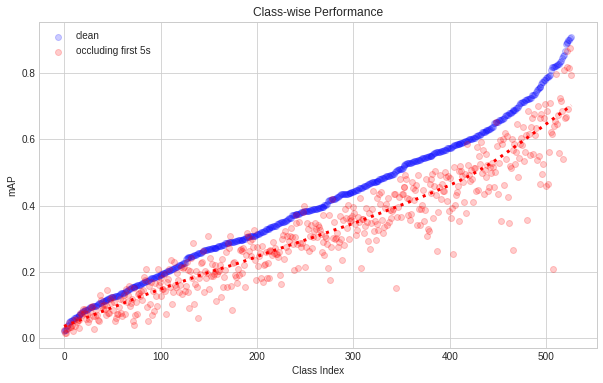

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding first 5s.png

In [44]:
plot_pair_data(classwise_data0, classwise_data2, 'clean', 'occluding first 5s')

<h>mid 5s</h>

In [45]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

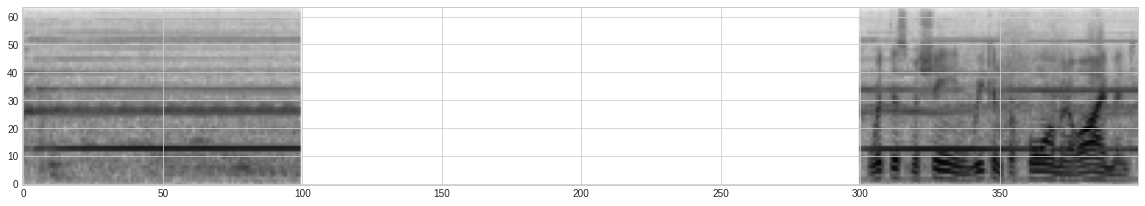

In [46]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [47]:
classwise_data3, glob_prob3= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.335 | 0.956 | 2.416 
---------+-------+-------+-------
       0 | 0.728 | 0.903 | 1.833 
       1 | 0.037 | 0.816 | 1.272 
       2 | 0.088 | 0.915 | 1.944 
       3 | 0.292 | 0.940 | 2.199 
       4 | 0.176 | 0.969 | 2.641 
       5 | 0.060 | 0.939 | 2.193 
       6 | 0.347 | 0.978 | 2.848 
       7 | 0.311 | 0.987 | 3.138 
       8 | 0.098 | 0.942 | 2.227 
       9 | 0.088 | 0.938 | 2.177 
      10 | 0.096 | 0.954 | 2.376 
      11 | 0.145 | 0.962 | 2.516 
      12 | 0.720 | 0.995 | 3.674 
      13 | 0.396 | 0.994 | 3.582 
      14 | 0.169 | 0.959 | 2.459 
      15 | 0.723 | 0.978 | 2.858 
      16 | 0.332 | 0.967 | 2.608 
      17 | 0.491 | 0.979 | 2.864 
      18 | 0.138 | 0.960 | 2.472 
      19 | 0.175 | 0.951 | 2.347 
      20 | 0.316 | 0.975 | 2.770 
      21 | 0.150 | 0.973 | 2.717 
      22 | 0.379 | 0.977 | 2.822 
      23 

31 of occluding mid 5s outperformed clean


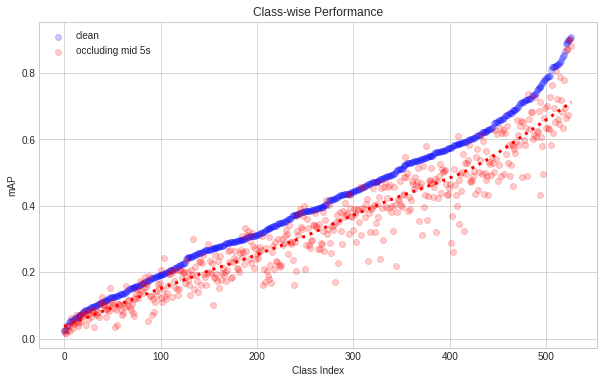

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding mid 5s.png

In [48]:
plot_pair_data(classwise_data0, classwise_data3, 'clean', 'occluding mid 5s')

<h>last 5s</h>

In [49]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

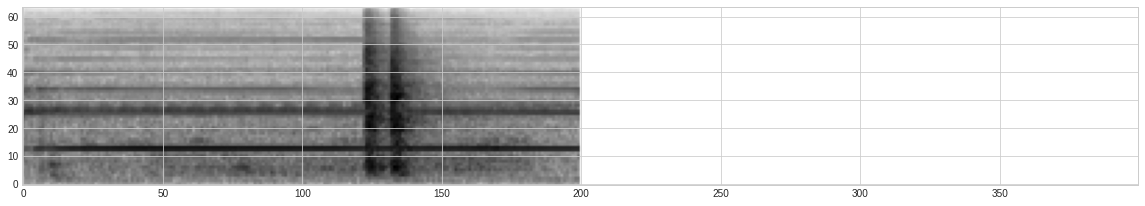

In [50]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

<h>Every 1s</h1>

In [51]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

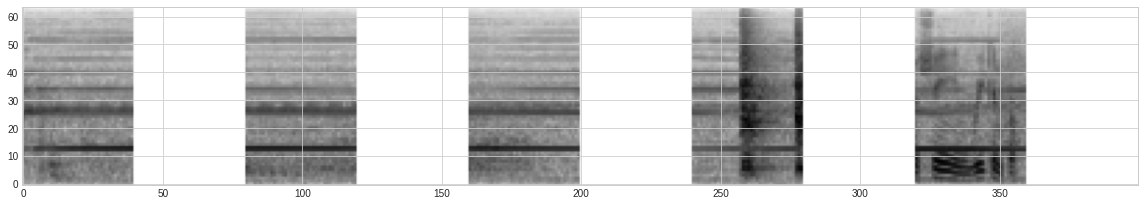

In [52]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [53]:
classwise_data4, glob_prob4= calculate_result_torch(new_gas_eval)# convert list to numpy array


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.319 | 0.956 | 2.417 
---------+-------+-------+-------
       0 | 0.737 | 0.908 | 1.876 
       1 | 0.061 | 0.784 | 1.109 
       2 | 0.068 | 0.909 | 1.891 
       3 | 0.256 | 0.948 | 2.302 
       4 | 0.115 | 0.965 | 2.567 
       5 | 0.057 | 0.947 | 2.289 
       6 | 0.335 | 0.977 | 2.829 
       7 | 0.272 | 0.982 | 2.955 
       8 | 0.127 | 0.927 | 2.052 
       9 | 0.097 | 0.930 | 2.091 
      10 | 0.090 | 0.948 | 2.301 
      11 | 0.177 | 0.960 | 2.473 
      12 | 0.765 | 0.998 | 4.009 
      13 | 0.333 | 0.994 | 3.543 
      14 | 0.187 | 0.951 | 2.346 
      15 | 0.723 | 0.993 | 3.473 
      16 | 0.343 | 0.968 | 2.619 
      17 | 0.551 | 0.988 | 3.215 
      18 | 0.097 | 0.947 | 2.281 
      19 | 0.137 | 0.962 | 2.506 
      20 | 0.348 | 0.975 | 2.779 
      21 | 0.128 | 0.964 | 2.541 
      22 | 0.399 | 0.982 | 2.968 
      23 

12 of occluding every 1s outperformed clean


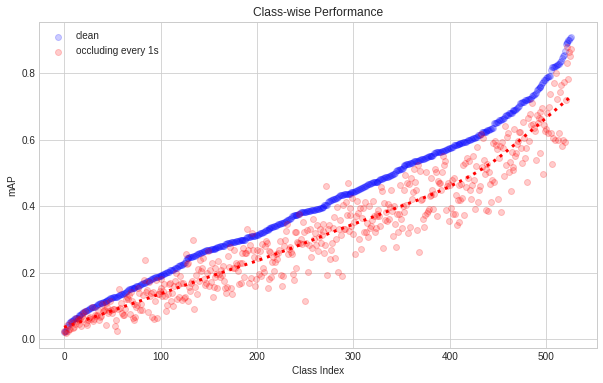

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding every 1s.png

In [54]:
plot_pair_data(classwise_data0, classwise_data4, 'clean', 'occluding every 1s')

<h>Every 0.5s</h1>

In [55]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

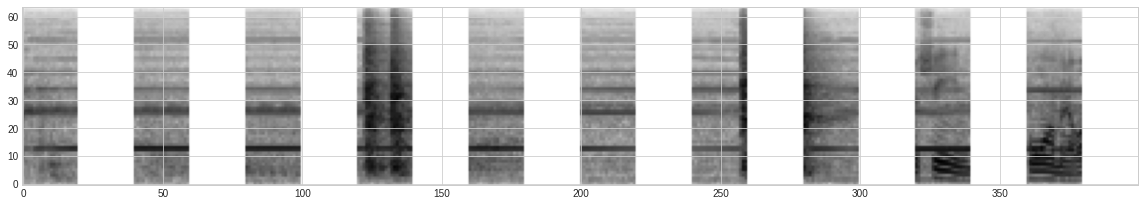

In [56]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [57]:
classwise_data5, glob_prob5= calculate_result_torch(new_gas_eval)# convert list to numpy array


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.233 | 0.937 | 2.163 
---------+-------+-------+-------
       0 | 0.686 | 0.891 | 1.743 
       1 | 0.040 | 0.753 | 0.967 
       2 | 0.074 | 0.900 | 1.814 
       3 | 0.230 | 0.938 | 2.174 
       4 | 0.151 | 0.955 | 2.404 
       5 | 0.050 | 0.940 | 2.203 
       6 | 0.227 | 0.979 | 2.869 
       7 | 0.180 | 0.973 | 2.717 
       8 | 0.087 | 0.931 | 2.102 
       9 | 0.084 | 0.918 | 1.972 
      10 | 0.068 | 0.955 | 2.393 
      11 | 0.080 | 0.955 | 2.404 
      12 | 0.617 | 0.995 | 3.616 
      13 | 0.243 | 0.989 | 3.230 
      14 | 0.138 | 0.951 | 2.336 
      15 | 0.734 | 0.995 | 3.598 
      16 | 0.341 | 0.969 | 2.634 
      17 | 0.405 | 0.977 | 2.810 
      18 | 0.092 | 0.953 | 2.362 
      19 | 0.124 | 0.953 | 2.374 
      20 | 0.181 | 0.977 | 2.834 
      21 | 0.065 | 0.947 | 2.291 
      22 | 0.224 | 0.971 | 2.676 
      23 

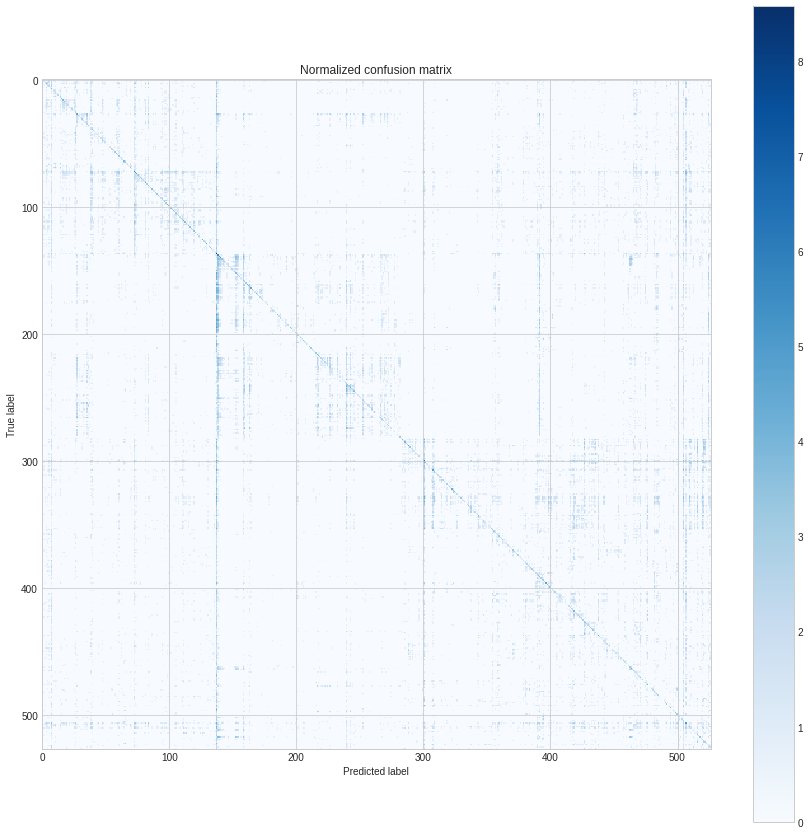

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [58]:
confusion5 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob5)
visualize_confusion(confusion5)

2 of occluding every 0.5s outperformed clean


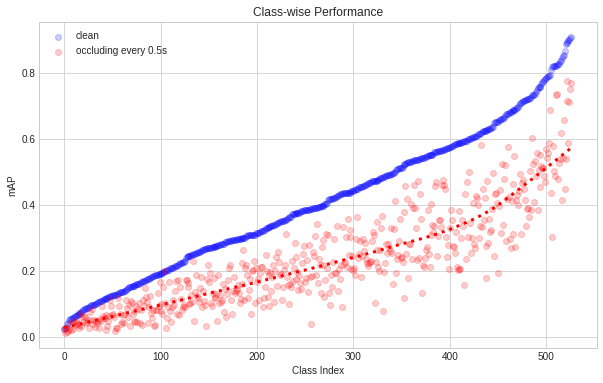

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding every 0.5s.png

In [59]:
plot_pair_data(classwise_data0, classwise_data5, 'clean', 'occluding every 0.5s')

<h>Every 0.25s</h1>

In [60]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

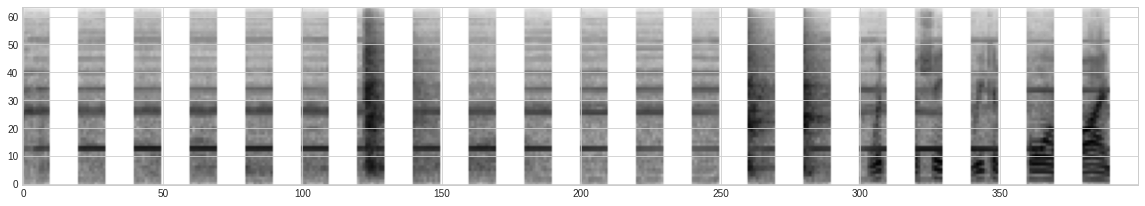

In [61]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [62]:
classwise_data6, glob_prob6= calculate_result_torch(new_gas_eval)# convert list to numpy array


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.041 | 0.757 | 0.985 
---------+-------+-------+-------
       0 | 0.504 | 0.768 | 1.037 
       1 | 0.004 | 0.589 | 0.318 
       2 | 0.012 | 0.773 | 1.060 
       3 | 0.068 | 0.826 | 1.326 
       4 | 0.014 | 0.834 | 1.372 
       5 | 0.019 | 0.858 | 1.518 
       6 | 0.045 | 0.936 | 2.157 
       7 | 0.016 | 0.863 | 1.547 
       8 | 0.005 | 0.671 | 0.626 
       9 | 0.007 | 0.680 | 0.662 
      10 | 0.008 | 0.761 | 1.004 
      11 | 0.004 | 0.640 | 0.508 
      12 | 0.015 | 0.842 | 1.416 
      13 | 0.019 | 0.794 | 1.159 
      14 | 0.010 | 0.798 | 1.178 
      15 | 0.390 | 0.974 | 2.759 
      16 | 0.083 | 0.890 | 1.734 
      17 | 0.081 | 0.897 | 1.789 
      18 | 0.074 | 0.892 | 1.753 
      19 | 0.048 | 0.868 | 1.582 
      20 | 0.047 | 0.914 | 1.931 
      21 | 0.045 | 0.862 | 1.537 
      22 | 0.017 | 0.819 | 1.290 
      23 

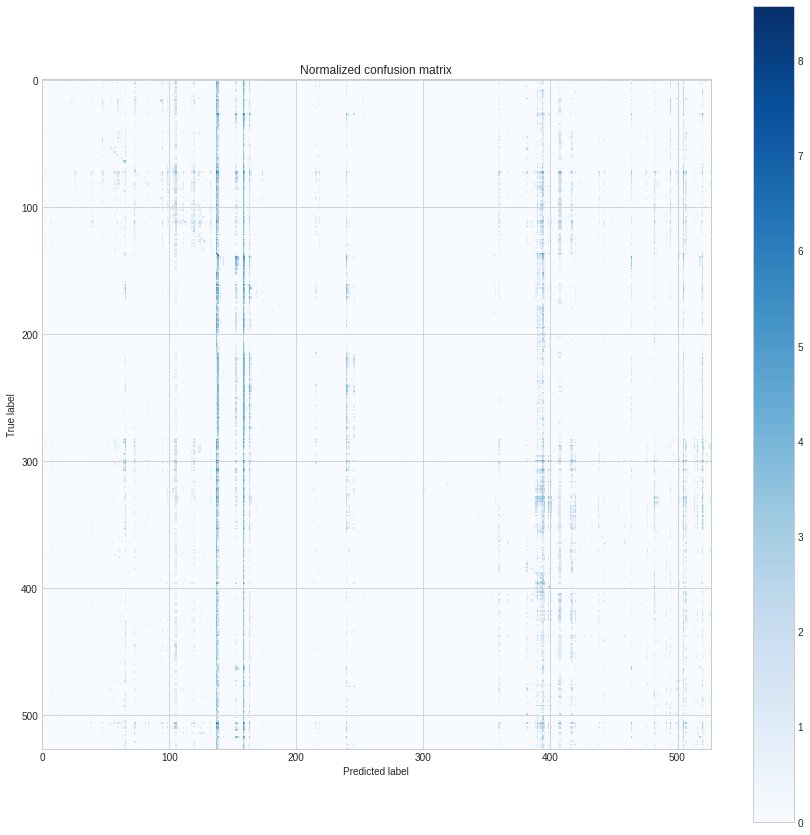

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [63]:
confusion6 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob6)
visualize_confusion(confusion6)

0 of occluding every 0.25s outperformed clean


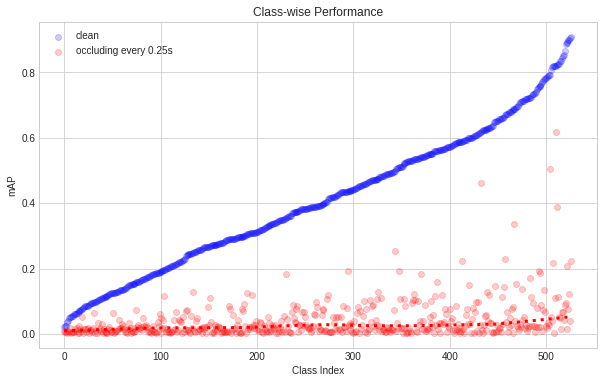

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding every 0.25s.png

In [64]:
plot_pair_data(classwise_data0, classwise_data6, 'clean', 'occluding every 0.25s')

<h>Every 0.125s</h1>

In [65]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

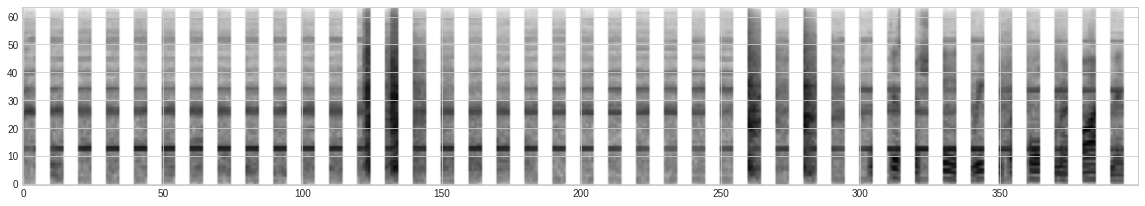

In [66]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [67]:
classwise_data7, glob_prob7= calculate_result_torch(new_gas_eval)# convert list to numpy array


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.020 | 0.675 | 0.642 
---------+-------+-------+-------
       0 | 0.430 | 0.696 | 0.724 
       1 | 0.005 | 0.603 | 0.370 
       2 | 0.011 | 0.729 | 0.861 
       3 | 0.035 | 0.725 | 0.847 
       4 | 0.011 | 0.816 | 1.273 
       5 | 0.010 | 0.719 | 0.821 
       6 | 0.016 | 0.876 | 1.636 
       7 | 0.005 | 0.700 | 0.743 
       8 | 0.004 | 0.502 | 0.006 
       9 | 0.007 | 0.628 | 0.460 
      10 | 0.006 | 0.727 | 0.852 
      11 | 0.004 | 0.651 | 0.551 
      12 | 0.005 | 0.612 | 0.401 
      13 | 0.025 | 0.772 | 1.055 
      14 | 0.004 | 0.608 | 0.389 
      15 | 0.212 | 0.972 | 2.700 
      16 | 0.029 | 0.786 | 1.122 
      17 | 0.020 | 0.803 | 1.207 
      18 | 0.017 | 0.823 | 1.309 
      19 | 0.011 | 0.740 | 0.910 
      20 | 0.015 | 0.780 | 1.090 
      21 | 0.013 | 0.796 | 1.168 
      22 | 0.009 | 0.741 | 0.912 
      23 

0 of occluding every 0.125s outperformed clean


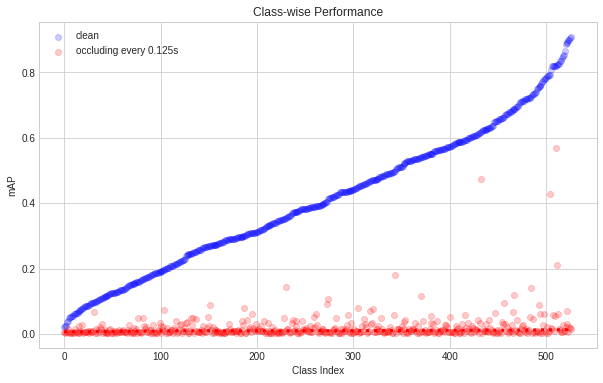

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_occluding every 0.125s.png

In [68]:
plot_pair_data(classwise_data0, classwise_data7, 'clean', 'occluding every 0.125s')

<h>concat 0.125s</h>

In [69]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

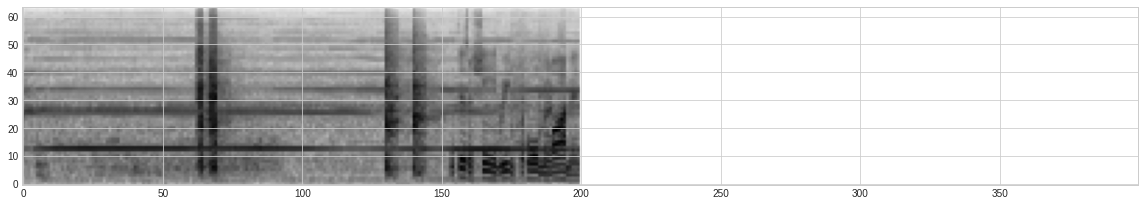

In [70]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [71]:
classwise_data8, glob_prob8= calculate_result_torch(new_gas_eval)# convert list to numpy array


total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.291 | 0.952 | 2.350 
---------+-------+-------+-------
       0 | 0.707 | 0.902 | 1.830 
       1 | 0.086 | 0.817 | 1.280 
       2 | 0.088 | 0.912 | 1.912 
       3 | 0.219 | 0.943 | 2.238 
       4 | 0.138 | 0.974 | 2.743 
       5 | 0.074 | 0.942 | 2.228 
       6 | 0.236 | 0.985 | 3.067 
       7 | 0.354 | 0.982 | 2.967 
       8 | 0.098 | 0.908 | 1.878 
       9 | 0.104 | 0.939 | 2.184 
      10 | 0.097 | 0.950 | 2.330 
      11 | 0.151 | 0.969 | 2.644 
      12 | 0.650 | 0.995 | 3.677 
      13 | 0.377 | 0.995 | 3.616 
      14 | 0.173 | 0.966 | 2.576 
      15 | 0.669 | 0.988 | 3.192 
      16 | 0.284 | 0.971 | 2.682 
      17 | 0.453 | 0.978 | 2.839 
      18 | 0.096 | 0.940 | 2.205 
      19 | 0.120 | 0.961 | 2.496 
      20 | 0.290 | 0.969 | 2.638 
      21 | 0.114 | 0.942 | 2.219 
      22 | 0.214 | 0.970 | 2.654 
      23 

13 of concat 0.125s fragments outperformed clean


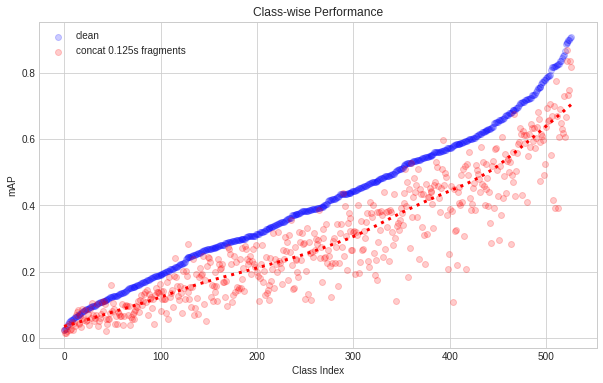

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_concat 0.125s fragments.png

In [72]:
plot_pair_data(classwise_data0, classwise_data8, 'clean', 'concat 0.125s fragments')

<h>concat 0.25s</h>

In [73]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

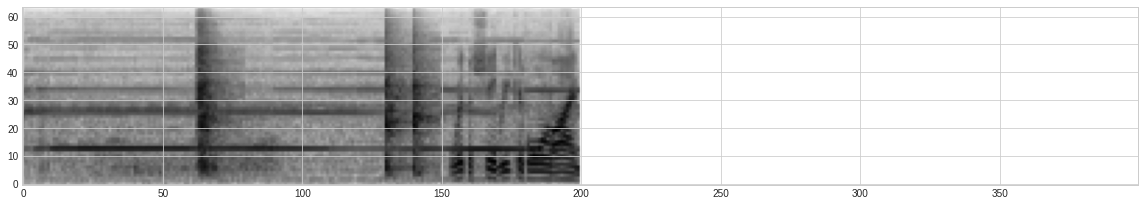

In [74]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

<h>concat 0.5s</h>

In [75]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

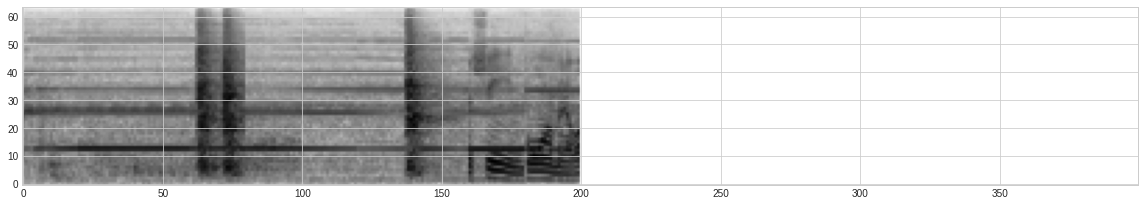

In [76]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

<h>concat 1s</h>

In [77]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

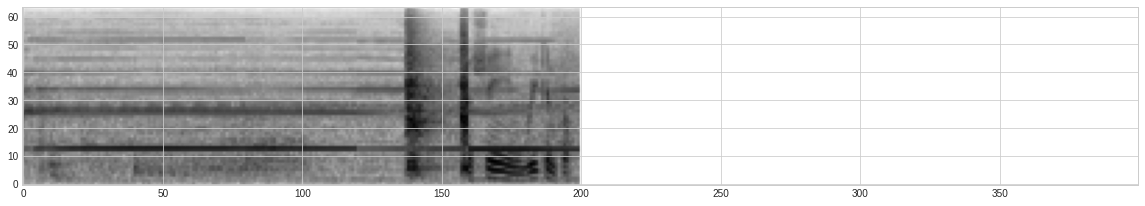

In [78]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

<h>White noise</h>

In [79]:
new_gas_eval = []
for record in gas_eval_x1:
#     noise = 0.1 * torch.rand_like(torch.tensor(record))
#     new_record = record + noise
    new_record = record + np.random.normal(0, 0.3, (400,64)).astype(np.float32)
    new_gas_eval.append(new_record)
new_gas_eval = numpy.array(new_gas_eval)

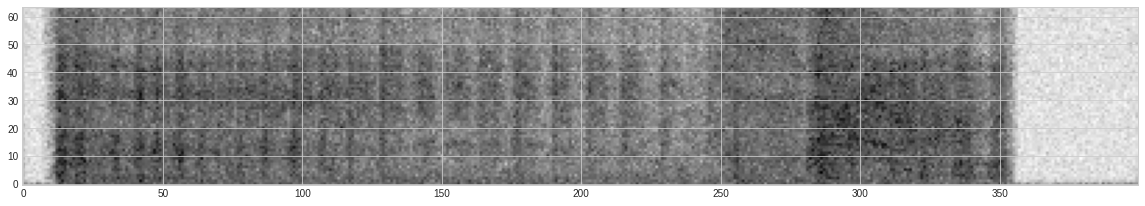

In [80]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[2].T, origin='lower')

In [81]:
classwise_data9, glob_prob9= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.055 | 0.799 | 1.185 
---------+-------+-------+-------
       0 | 0.606 | 0.841 | 1.412 
       1 | 0.007 | 0.724 | 0.842 
       2 | 0.046 | 0.867 | 1.576 
       3 | 0.115 | 0.905 | 1.851 
       4 | 0.081 | 0.949 | 2.313 
       5 | 0.076 | 0.907 | 1.867 
       6 | 0.061 | 0.901 | 1.822 
       7 | 0.248 | 0.954 | 2.381 
       8 | 0.008 | 0.776 | 1.074 
       9 | 0.003 | 0.577 | 0.275 
      10 | 0.007 | 0.611 | 0.399 
      11 | 0.004 | 0.614 | 0.408 
      12 | 0.029 | 0.911 | 1.908 
      13 | 0.038 | 0.792 | 1.149 
      14 | 0.053 | 0.911 | 1.906 
      15 | 0.360 | 0.984 | 3.050 
      16 | 0.198 | 0.897 | 1.789 
      17 | 0.091 | 0.946 | 2.276 
      18 | 0.040 | 0.913 | 1.919 
      19 | 0.037 | 0.914 | 1.931 
      20 | 0.055 | 0.927 | 2.052 
      21 | 0.021 | 0.838 | 1.398 
      22 | 0.067 | 0.880 | 1.661 
      23 

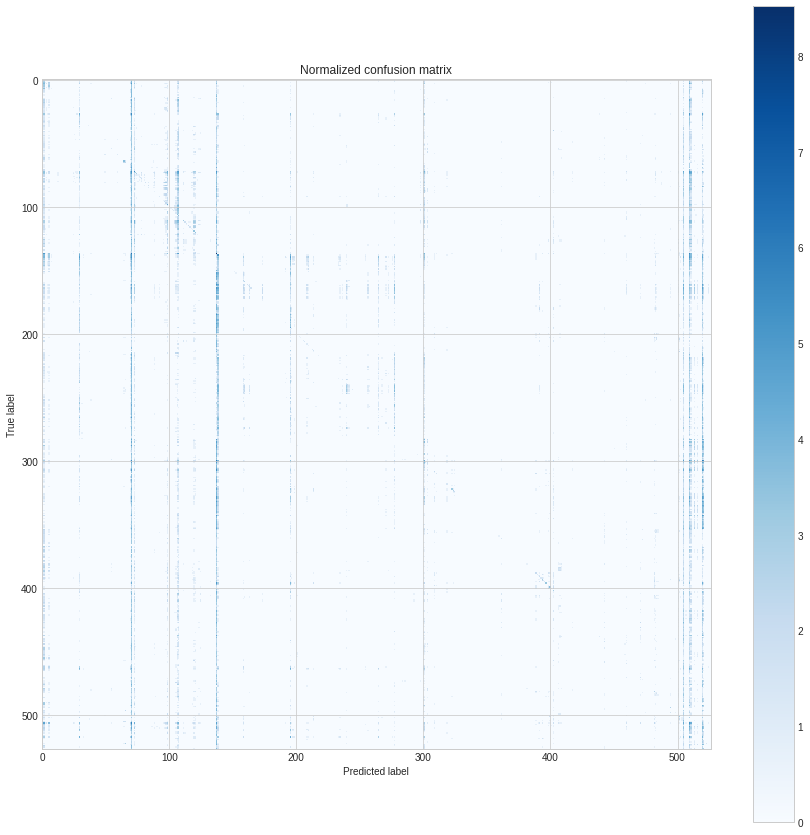

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/confusion_matrix.png

In [82]:
confusion9 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob9)
visualize_confusion(confusion9)

0 of whitenoise outperformed clean


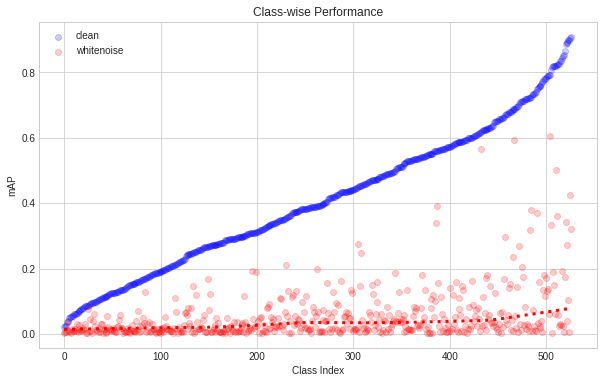

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src/performance_classwise_clean_whitenoise.png

In [83]:
plot_pair_data(classwise_data0, classwise_data9, 'clean', 'whitenoise')

In [188]:
from torch.cuda.amp import autocast,GradScaler

In [15]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.2922494 1.4197426


In [189]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=50, shuffle=True)

In [212]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCEWithLogitsLoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check
            with autocast():
                out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

                loss = criterion(out, y.to('cuda', non_blocking=True))
                loss_global += loss.item()
#                 print(loss.item(), loss_global)
                loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/(_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)+1e-7)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [230]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.05, eps_norm='inf', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), y_target=None )

global loss:5.29603872820735
global loss:5.294041223824024
global loss:5.295134759508073
global loss:5.29710472933948
global loss:5.3066142266616225
global loss:5.349480680190027
global loss:5.78561903629452
global loss:7.088376292958856
global loss:8.516758242622018
global loss:9.734202539548278
global loss:10.700871910899878
global loss:11.374874962493777
global loss:11.871614083647728
global loss:12.285886326804757
global loss:12.64162228628993
global loss:12.92504120990634
global loss:13.132814150303602
global loss:13.28356696292758
global loss:13.393842155113816
global loss:13.473648626357317


In [231]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

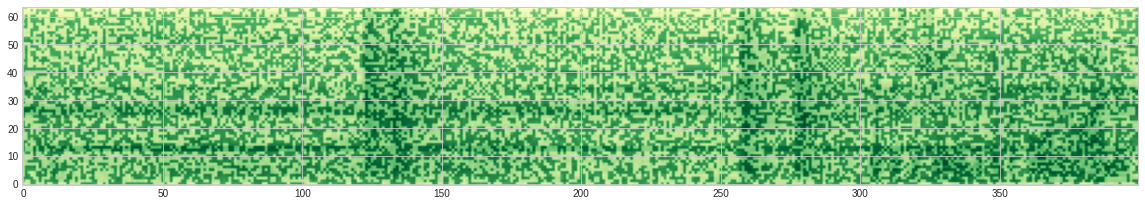

In [232]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower',cmap='YlGn')

In [233]:
classwise_data11, glob_prob11= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.012 | 0.646 | 0.531 
---------+-------+-------+-------
       0 | 0.398 | 0.687 | 0.689 
       1 | 0.003 | 0.539 | 0.137 
       2 | 0.007 | 0.736 | 0.893 
       3 | 0.021 | 0.709 | 0.778 
       4 | 0.009 | 0.804 | 1.210 
       5 | 0.071 | 0.900 | 1.810 
       6 | 0.011 | 0.827 | 1.332 
       7 | 0.075 | 0.922 | 2.010 
       8 | 0.004 | 0.619 | 0.427 
       9 | 0.006 | 0.651 | 0.551 
      10 | 0.003 | 0.495 |-0.019 
      11 | 0.003 | 0.487 |-0.047 
      12 | 0.010 | 0.837 | 1.388 
      13 | 0.006 | 0.726 | 0.850 
      14 | 0.008 | 0.695 | 0.722 
      15 | 0.022 | 0.927 | 2.053 
      16 | 0.015 | 0.753 | 0.968 
      17 | 0.020 | 0.710 | 0.784 
      18 | 0.006 | 0.728 | 0.857 
      19 | 0.005 | 0.723 | 0.838 
      20 | 0.005 | 0.653 | 0.555 
      21 | 0.004 | 0.604 | 0.372 
      22 | 0.004 | 0.616 | 0.418 
      23 

In [219]:
np.save('classwise_data_inf.npy', classwise_data11)
np.save('glob_prob_inf.npy', glob_prob11)

In [220]:
np.save('perturb_inf.npy', perturb.cpu().numpy())

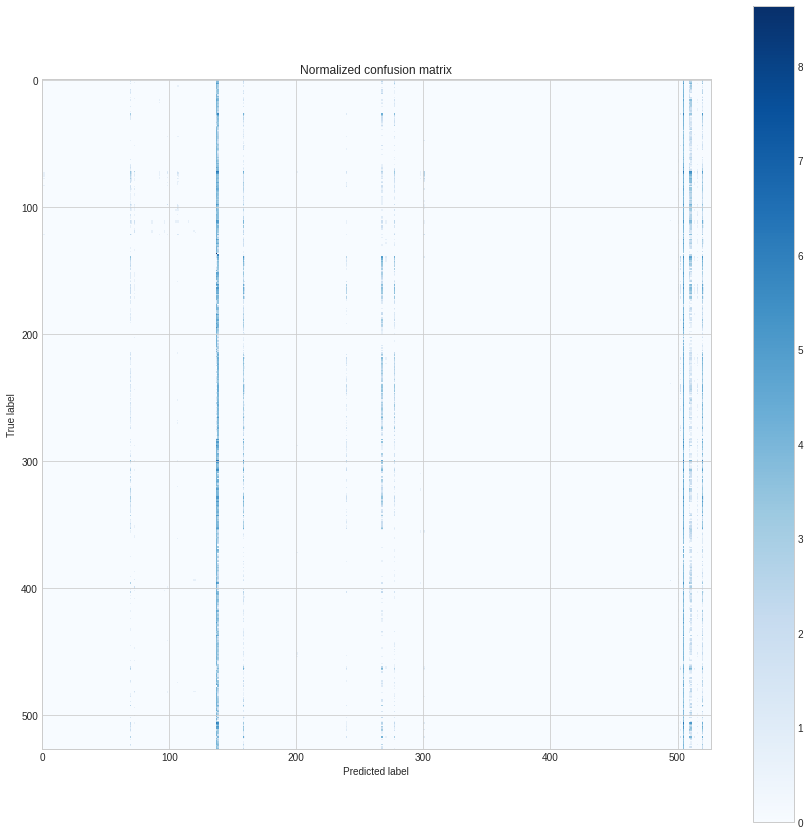

/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/confusion_matrix.png

In [234]:
confusion11 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob11)
visualize_confusion(confusion11)

In [222]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.05, eps_norm='2', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), y_target=None )

global loss:5.293454312719405
global loss:5.3024309212341905
global loss:5.327355217188597
global loss:5.391648722812533
global loss:5.500096660107374
global loss:5.649296618998051
global loss:5.843947223387659
global loss:6.077675129286945
global loss:6.3424436170607805
global loss:6.625727234408259
global loss:6.915601724758744
global loss:7.201960785314441
global loss:7.475583775900304
global loss:7.729950875043869
global loss:7.9744943752884865
global loss:8.208391951397061
global loss:8.430845720693469
global loss:8.645131054334342
global loss:8.850616542622447
global loss:9.050147229805589


In [223]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

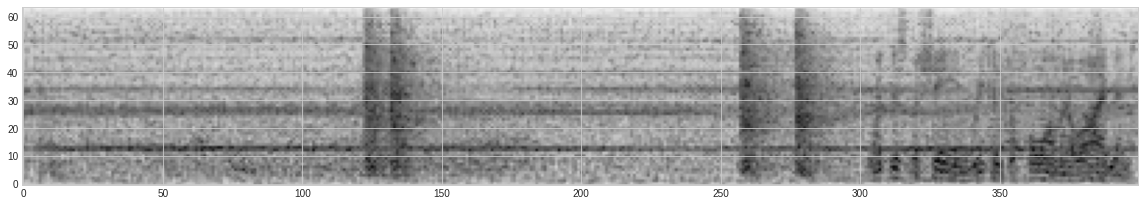

In [224]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [225]:
classwise_data12, glob_prob12= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.157 | 0.898 | 1.797 
---------+-------+-------+-------
       0 | 0.661 | 0.883 | 1.686 
       1 | 0.013 | 0.748 | 0.945 
       2 | 0.054 | 0.898 | 1.793 
       3 | 0.168 | 0.934 | 2.125 
       4 | 0.197 | 0.961 | 2.500 
       5 | 0.067 | 0.935 | 2.143 
       6 | 0.174 | 0.965 | 2.554 
       7 | 0.377 | 0.978 | 2.838 
       8 | 0.021 | 0.872 | 1.604 
       9 | 0.013 | 0.826 | 1.329 
      10 | 0.085 | 0.905 | 1.852 
      11 | 0.020 | 0.884 | 1.694 
      12 | 0.482 | 0.990 | 3.301 
      13 | 0.407 | 0.984 | 3.042 
      14 | 0.196 | 0.953 | 2.370 
      15 | 0.534 | 0.978 | 2.842 
      16 | 0.288 | 0.946 | 2.271 
      17 | 0.436 | 0.972 | 2.695 
      18 | 0.142 | 0.957 | 2.429 
      19 | 0.079 | 0.945 | 2.257 
      20 | 0.181 | 0.976 | 2.806 
      21 | 0.061 | 0.934 | 2.133 
      22 | 0.249 | 0.975 | 2.776 
      23 

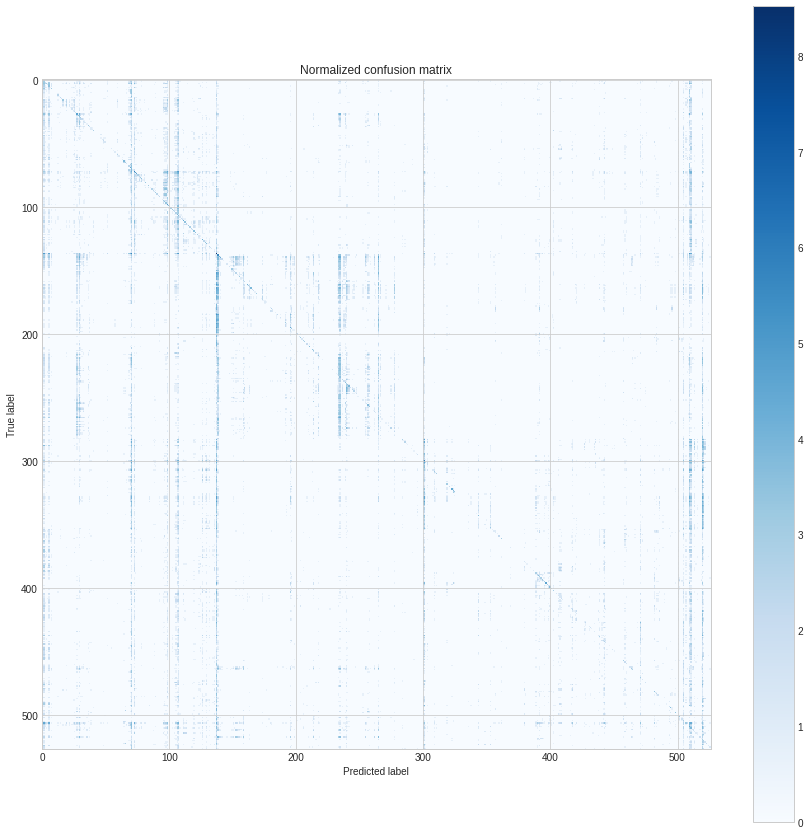

/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/confusion_matrix.png

In [226]:
confusion12 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob12)
visualize_confusion(confusion12)

<h>Strong</h1>

In [227]:
hf_val_eval_path = os.path.join(local, 'data_64_400_noise0.15.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

new_gas_eval, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [228]:
classwise_data13, glob_prob13= calculate_result_torch(new_gas_eval)

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
 Average | 0.152 | 0.835 | 1.375 
---------+-------+-------+-------
       0 | 0.634 | 0.847 | 1.446 
       1 | 0.017 | 0.784 | 1.113 
       2 | 0.051 | 0.823 | 1.312 
       3 | 0.224 | 0.927 | 2.052 
       4 | 0.017 | 0.875 | 1.630 
       5 | 0.017 | 0.855 | 1.499 
       6 | 0.064 | 0.875 | 1.626 
       7 | 0.106 | 0.917 | 1.963 
       8 | 0.090 | 0.875 | 1.629 
       9 | 0.081 | 0.863 | 1.547 
      10 | 0.094 | 0.941 | 2.206 
      11 | 0.113 | 0.958 | 2.449 
      12 | 0.733 | 0.993 | 3.478 
      13 | 0.425 | 0.988 | 3.170 
      14 | 0.167 | 0.928 | 2.065 
      15 | 0.002 | 0.186 |-1.265 
      16 | 0.279 | 0.944 | 2.252 
      17 | 0.269 | 0.963 | 2.529 
      18 | 0.073 | 0.934 | 2.133 
      19 | 0.143 | 0.923 | 2.014 
      20 | 0.137 | 0.957 | 2.427 
      21 | 0.056 | 0.903 | 1.837 
      22 | 0.113 | 0.885 | 1.701 
      23 

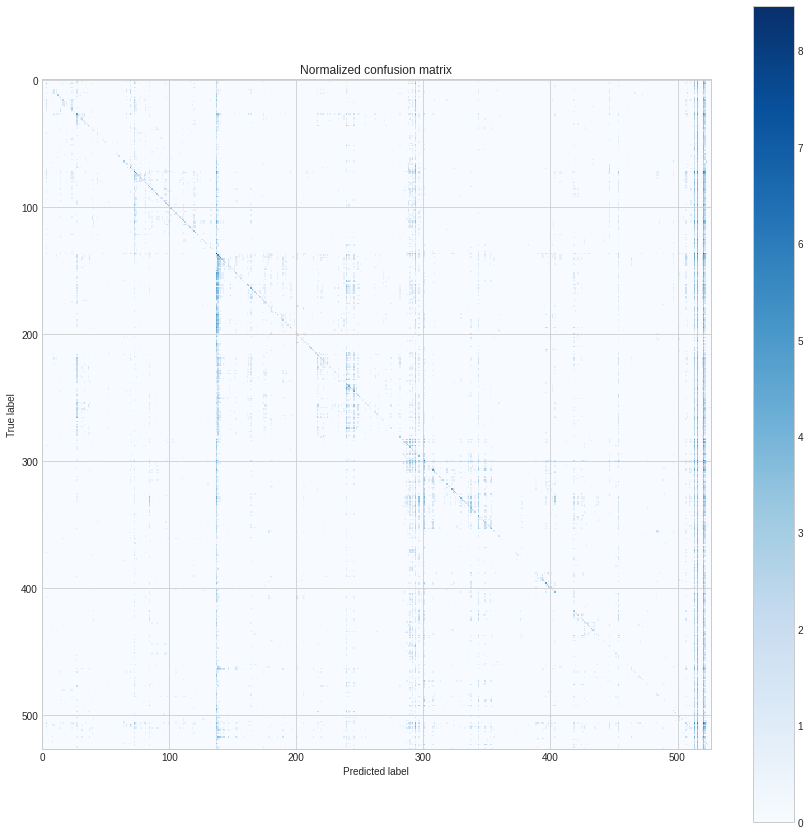

/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/confusion_matrix.png

In [229]:
confusion13 = multiclass_confusion_matrix_numpy(gas_eval_y, glob_prob13)
visualize_confusion(confusion13)